## Twitter Sentiment Analysis - Natural Language Processing

### Importing Libraries and Data

In [ ]:
# Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report, f1_score
import re
from sklearn import svm
from sklearn.metrics import f1_score, make_scorer, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
!pip install textattack
from textattack.augmentation import WordNetAugmenter
from keras import backend as K

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.7/418.7 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 KB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 MB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.9/401.9 KB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 KB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 78.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 KB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount("/content/drive")

# Connect to .csv files from Google drive
train = "/content/drive/MyDrive/Colab Notebooks/Machine_Learning/Tweets_train.csv"
test = "/content/drive/MyDrive/Colab Notebooks/Machine_Learning/Tweets_test (1).csv"
valid = "/content/drive/MyDrive/Colab Notebooks/Machine_Learning/Tweets_dev.csv"

# Creating Dataframes
df_train = pd.read_csv(train)
df_test = pd.read_csv(test, encoding_errors= 'replace')
df_valid = pd.read_csv(valid)

# Merging Dataframes
df = pd.concat([df_train,df_valid])
df.reset_index(inplace=True,drop=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Basic Data Exploration

In [ ]:
# Display dataframe dimensions
print(df.shape)
print(df_test.shape)

(13176, 3)
(1464, 3)


In [ ]:
# Check for null columns
print(df.isnull().sum())
print(df_test.isnull().sum())

tweet_id             0
text                 0
airline_sentiment    0
dtype: int64
tweet_id             0
text                 0
airline_sentiment    0
dtype: int64


In [ ]:
# Check unique values in column
df['airline_sentiment'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Sentiment Type')

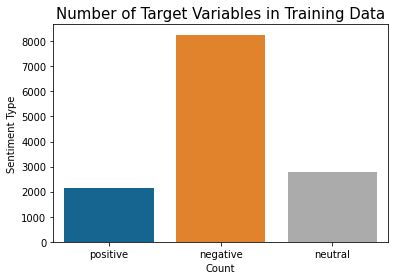

In [ ]:
plt.style.use('tableau-colorblind10')
sns.countplot(df["airline_sentiment"])
plt.title("Number of Target Variables in Training Data", loc="center", fontsize=15)
plt.xlabel("Count")
plt.ylabel("Sentiment Type")

### Data Preprocssing

In [ ]:
# Create function to change target value into numerical
def y_value_encoding(df):
  df.replace(to_replace ="positive", value = 0, inplace=True)
  df.replace(to_replace ="negative", value = 1, inplace=True)
  df.replace(to_replace ="neutral", value = 2 , inplace=True)

In [ ]:
# Chaning the value of tagret variable to numerical
y_value_encoding(df["airline_sentiment"])
# Displaying the first 10 rows
df.head(10)

,tweet_id,text,airline_sentiment
0,569179849518161920,@united you're good. Thank you!,0
1,569835751275433984,"@AmericanAir way to ruin a vacation, my brothe...",1
2,568588936852799488,@JetBlue yes thankfully! Catering just got her...,0
3,569525116725567491,@USAirways The automated message isn't helpful...,1
4,568807823187976193,@JetBlue I'm #MakingLoveOutofNothingAtAll on m...,0
5,569617089155211265,@AmericanAir just downloaded the app for iPhon...,2
6,568081386520723456,.@united Don't post a link to an article that ...,1
7,570287303681294337,@JetBlue I'm not sure if you can do anything t...,2
8,569658686999818241,"@AmericanAir My baggage is lost, my flight Can...",1
9,569377633894445056,@USAirways Charlotte Staff needs prayer....dis...,1


In [ ]:
# Chaning the value of tagret variable to numerical in test data
y_value_encoding(df_test["airline_sentiment"])
# Displaying the first 10 rows
df_test.head(10)

,tweet_id,text,airline_sentiment
0,570252000000000000,@AmericanAir I need refund.,1
1,568173000000000000,@USAirways after 3 Cancelled Flightlations and...,1
2,569321000000000000,@JetBlue thanks so much. Can't wait to fly wit...,0
3,569503000000000000,@united I have never been more frustrated than...,1
4,568981000000000000,"@USAirways - the worst! Hold time crazy, agent...",1
5,569933000000000000,"@AmericanAir My pleasure, next AA flight - thi...",0
6,570116000000000000,@united frankly worse customer service ever. P...,1
7,568467000000000000,@SouthwestAir you need to get your act togethe...,1
8,570280000000000000,@AmericanAir AND they Cancelled Flighted my fl...,1
9,568898000000000000,@JetBlue flight 691 from bos to Tampa takeoff ...,1


In [ ]:
# Initiating Lemmatizer
lm = WordNetLemmatizer()

# Define function to clean text data
def transforming_text(col):
    output = []
    for i in col:
        new_i = re.sub('[^a-zA-Z]',' ',str(i))
        new_i = new_i.lower()
        new_i = new_i.split()
        new_i = [lm.lemmatize(word) for word in new_i if word not in set(stopwords.words('english'))]
        output.append(' '.join(str(x) for x in new_i))
    return output

In [ ]:
# Cleaning text data
df["text"] = transforming_text(df['text'])
df_test["text"] = transforming_text(df_test["text"])

In [ ]:
# Display first 5 rows
df.drop(["tweet_id"], axis=1, inplace=True)
df.head()

,text,airline_sentiment
0,united good thank,0
1,americanair way ruin vacation brother called n...,1
2,jetblue yes thankfully catering got loading fr...,0
3,usairways automated message helpful impossible...,1
4,jetblue makingloveoutofnothingatall brandlovea...,0


In [ ]:
# Display first 5 rows
df_test.drop(["tweet_id"], axis=1, inplace=True)
df_test

,text,airline_sentiment
0,americanair need refund,1
1,usairways cancelled flightlations delay causin...,1
2,jetblue thanks much wait fly guy,0
3,united never frustrated conversation united sp...,1
4,usairways worst hold time crazy agent horrible...,1
...,...,...
1459,americanair miss flight american airline gave ...,1
1460,usairways sitting hold hr flight cancelled fli...,1
1461,southwestair great flight damion best damionfl...,0
1462,americanair aa return jfk thanks,2


In [ ]:
# Text augmentation

def text_augmentation(dataf):
  augmented_rows = pd.DataFrame(columns = ["text", "airline_sentiment"])
  temp_dataf = dataf[(dataf["airline_sentiment"]==0) | (dataf["airline_sentiment"]==2)]
  augmenter = WordNetAugmenter()
  for index, row in temp_dataf.iterrows():
    augmented_text = augmenter.augment(row[0])
    augmented_rows = augmented_rows.append({'text': augmented_text, "airline_sentiment":row[1]},
                                            ignore_index=True)
  augmented_rows["text"] = augmented_rows["text"].apply(lambda x: x[0])
  dataf = pd.concat([dataf, augmented_rows])
  dataf.reset_index(drop=True, inplace=True)
  dataf["airline_sentiment"] = dataf["airline_sentiment"].apply(lambda x: int(x))
  return dataf

df = text_augmentation(df)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Sentiment Type')

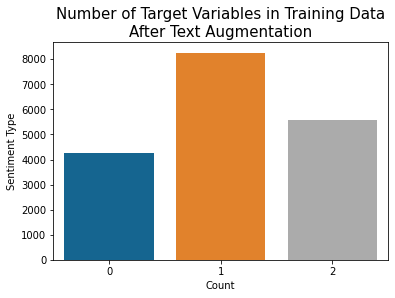

In [ ]:
plt.style.use('tableau-colorblind10')
sns.countplot(df["airline_sentiment"])
plt.title("Number of Target Variables in Training Data\nAfter Text Augmentation", loc="center", fontsize=15)
plt.xlabel("Count")
plt.ylabel("Sentiment Type")

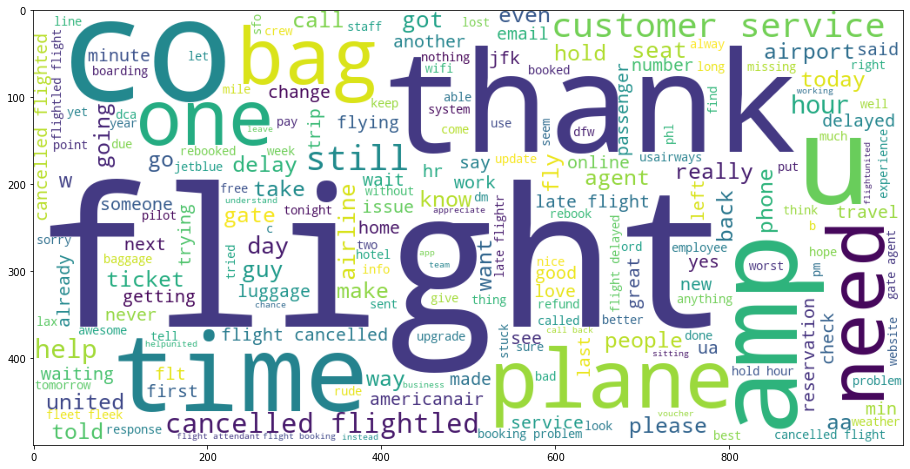

In [ ]:
# Display the most important words
plt.figure(figsize=(20,8))
word_cloud = ""
for row in df["text"]:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

In [ ]:
df.isnull().sum()

text                 0
airline_sentiment    0
dtype: int64

In [ ]:
# Change words to numerical form using Count Vectorizer
cv = CountVectorizer(ngram_range=(1,2))
x_train = cv.fit_transform(df["text"].values)
y_train = df["airline_sentiment"]
x_test = cv.transform(df_test["text"].values)
y_test = df_test["airline_sentiment"]

In [ ]:
# Display the dimension
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(18092, 98411)
(18092,)
(1464, 98411)
(1464,)


In [ ]:
# Display few rows of dataframe
y_train

0        0
1        1
2        0
3        1
4        0
        ..
18087    2
18088    2
18089    2
18090    2
18091    0
Name: airline_sentiment, Length: 18092, dtype: int64

In [ ]:
# Display few rows of dataframe
y_test

0       1
1       1
2       0
3       1
4       1
       ..
1459    1
1460    1
1461    0
1462    2
1463    1
Name: airline_sentiment, Length: 1464, dtype: int64

### Model Creation and Implementation

#### NLP - Random Forest

In [ ]:
# Initialise the model
classifier_1 = RandomForestClassifier(bootstrap=True, max_features="auto",n_estimators=500,random_state=0)

# Train the model
classifier_1.fit(x_train, y_train)

# Predict the target variable with test data
y_pred_1 = classifier_1.predict(x_test)

In [ ]:
# Recording the respective f1 score
rf_f1 = round(f1_score(y_test, y_pred_1, average="weighted"),2)

# Display the classification report
print(classification_report(y_test,y_pred_1))

              precision    recall  f1-score   support

           0       0.70      0.57      0.63       236
           1       0.84      0.87      0.85       918
           2       0.55      0.56      0.55       310

    accuracy                           0.76      1464
   macro avg       0.69      0.67      0.68      1464
weighted avg       0.75      0.76      0.75      1464



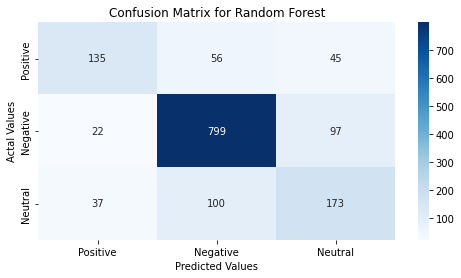

In [ ]:
# Perform confusion matrix calculation
cm = confusion_matrix(y_test, y_pred_1)

# Display the confusion matrix
cm_df = pd.DataFrame(cm,
                     index = ["Positive", "Negative", "Neutral"],
                     columns = ["Positive", "Negative", "Neutral"])
plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True, fmt ='g',cmap = 'Blues')
plt.title('Confusion Matrix for Random Forest')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

#### NLP - SVM

In [ ]:
# Set up hyperparameters for grid search
parameters_svm ={
    "C":[0.1,1,10],
    "kernel":['linear', 'rbf', 'sigmoid'],
    "gamma":['scale', 'auto']
}

# Initialise grid search to find the best parameter
svm_gridsearch = GridSearchCV(svm.SVC(probability=True, random_state=1), 
                              param_grid=parameters_svm, 
                              scoring="f1_weighted", 
                              verbose=3)
# Train the model
svm_gridsearch.fit(x_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.870 total time= 2.0min
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.870 total time= 2.1min
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.871 total time= 2.0min
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.872 total time= 2.0min
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.864 total time= 2.0min
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.609 total time= 2.7min
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.610 total time= 2.7min
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.611 total time= 2.7min
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.618 total time= 2.7min
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.604 total time= 2.7min
[CV 1/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.666 total time= 2.5min
[CV 2/5] END C=0.1, gamma=scale, kernel=sigmoid;

GridSearchCV(estimator=SVC(probability=True, random_state=1),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             scoring='f1_weighted', verbose=3)

In [ ]:
# Display the best parameters after running grid search
svm_gridsearch.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
# Predict the tatget variable for test data
y_pred_2 = svm_gridsearch.predict(x_test)

# store the f1 score of the respective model
svm_f1 = round(f1_score(y_test, y_pred_2, average="weighted"),2)

# Display the classification report
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.69      0.64      0.67       236
           1       0.87      0.83      0.85       918
           2       0.54      0.63      0.58       310

    accuracy                           0.76      1464
   macro avg       0.70      0.70      0.70      1464
weighted avg       0.77      0.76      0.76      1464



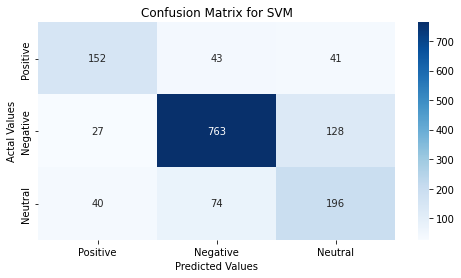

In [ ]:
# Perform confusion matrix calculation
cm = confusion_matrix(y_test, y_pred_2)

# Display the confusion matrix
cm_df = pd.DataFrame(cm,
                     index = ["Positive", "Negative", "Neutral"],
                     columns = ["Positive", "Negative", "Neutral"])
plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True, fmt ='g',cmap = 'Blues')
plt.title('Confusion Matrix for SVM')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

#### NLP - LSTM

In [ ]:
# Display dataframe
df

,text,airline_sentiment
0,united good thank,0
1,americanair way ruin vacation brother called n...,1
2,jetblue yes thankfully catering got loading fr...,0
3,usairways automated message helpful impossible...,1
4,jetblue makingloveoutofnothingatall brandlovea...,0
...,...,...
18087,united sector whereby say bag base allowance i...,2
18088,jetblue cpap machine sleep apnea ok stockpile ...,2
18089,usairways thank suppose website,2
18090,americanair well cleared custom auh need vex i...,2


In [ ]:
# Display dataframe
df_test

,text,airline_sentiment
0,americanair need refund,1
1,usairways cancelled flightlations delay causin...,1
2,jetblue thanks much wait fly guy,0
3,united never frustrated conversation united sp...,1
4,usairways worst hold time crazy agent horrible...,1
...,...,...
1459,americanair miss flight american airline gave ...,1
1460,usairways sitting hold hr flight cancelled fli...,1
1461,southwestair great flight damion best damionfl...,0
1462,americanair aa return jfk thanks,2


In [ ]:
# Merge and Display dataframes
df_lstm = pd.concat([df,df_test])
df_lstm.reset_index(inplace=True,drop=True)
df_lstm

,text,airline_sentiment
0,united good thank,0
1,americanair way ruin vacation brother called n...,1
2,jetblue yes thankfully catering got loading fr...,0
3,usairways automated message helpful impossible...,1
4,jetblue makingloveoutofnothingatall brandlovea...,0
...,...,...
19551,americanair miss flight american airline gave ...,1
19552,usairways sitting hold hr flight cancelled fli...,1
19553,southwestair great flight damion best damionfl...,0
19554,americanair aa return jfk thanks,2


In [ ]:
# Initialise tokenizer
token = Tokenizer(num_words=500, split=' ')

# Train tokernizer 
token.fit_on_texts(df_lstm['text'].values)
X = token.texts_to_sequences(df_lstm['text'].values)
X = pad_sequences(X)

# One hot encode target variable
y=pd.get_dummies(df_lstm['airline_sentiment'])

In [ ]:
# Display dimension
X.shape

(19556, 21)

In [ ]:
# Display dimension
y.shape

(19556, 3)

In [ ]:
# Split data into trin and test
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [ ]:
# Code to get multiple metrics for the deep learning model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Initialise deep learning model
classifier_4 = Sequential()
classifier_4.add(Embedding(500, 120, input_length = X.shape[1]))
classifier_4.add(SpatialDropout1D(0.4))
classifier_4.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
classifier_4.add(Dense(3,activation='softmax'))
classifier_4.compile(loss = 'categorical_crossentropy', optimizer='adam', 
                     metrics = ['accuracy',f1_m,precision_m, recall_m])
print(classifier_4.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 120)           60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 21, 120)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 3)                 531       
                                                                 
Total params: 269,619
Trainable params: 269,619
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Train the model
classifier_4.fit(x_train, y_train, epochs = 15, batch_size=32, verbose = 'auto')

Epoch 1/15
428/428 [==============================] - 45s 92ms/step - loss: 0.7593 - accuracy: 0.6700 - f1_m: 0.5946 - precision_m: 0.7094 - recall_m: 0.5259
Epoch 2/15
428/428 [==============================] - 42s 97ms/step - loss: 0.6308 - accuracy: 0.7363 - f1_m: 0.7222 - precision_m: 0.7683 - recall_m: 0.6826
Epoch 3/15
428/428 [==============================] - 39s 91ms/step - loss: 0.6067 - accuracy: 0.7478 - f1_m: 0.7369 - precision_m: 0.7746 - recall_m: 0.7038
Epoch 4/15
428/428 [==============================] - 40s 93ms/step - loss: 0.5918 - accuracy: 0.7513 - f1_m: 0.7440 - precision_m: 0.7802 - recall_m: 0.7121
Epoch 5/15
428/428 [==============================] - 39s 91ms/step - loss: 0.5776 - accuracy: 0.7570 - f1_m: 0.7507 - precision_m: 0.7867 - recall_m: 0.7190
Epoch 6/15
428/428 [==============================] - 42s 99ms/step - loss: 0.5593 - accuracy: 0.7670 - f1_m: 0.7614 - precision_m: 0.7927 - recall_m: 0.7334
Epoch 7/15
428/428 [==============================] 

In [ ]:
# Find loass and accuracy using test data
model_scores = classifier_4.evaluate(x_test,y_test)
LSTM_f1 = round(model_scores[2],2)

184/184 [==============================] - 2s 8ms/step - loss: 0.6312 - accuracy: 0.7587 - f1_m: 0.7547 - precision_m: 0.7743 - recall_m: 0.7368


### Comparing F1 Scores

In [ ]:
# Displaying f1 scores of all models
print("F1-Score of the Random Forest Model is : ", rf_f1)
print("F1-Score of the SVM Model is : ", svm_f1)
print("F1-Score of the Naive Bayes Model is : ", NB_f1)
print("F1-Score of the LSTM Deep Learning Model is : ", LSTM_f1)

F1-Score of the Random Forest Model is :  0.75
F1-Score of the SVM Model is :  0.76
F1-Score of the Naive Bayes Model is :  0.76
F1-Score of the LSTM Deep Learning Model is :  0.75
